## 1. Import Required Libraries

In [3]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import json
import warnings
warnings.filterwarnings('ignore')

# Hugging Face imports
try:
    from transformers import AutoImageProcessor, AutoModelForImageClassification, ViTForImageClassification
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    HF_AVAILABLE = True
    print("Hugging Face transformers available")
except ImportError:
    HF_AVAILABLE = False
    print("Hugging Face transformers not available. Install with: pip install transformers")

# Captum imports
from captum.attr import GradientShap, IntegratedGradients, Saliency
from captum.attr import visualization as viz

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Hugging Face transformers available
Using device: cpu
PyTorch version: 2.9.1


## 2. Load Pretrained Model and Setup

In [23]:
# Model selection: Choose between torchvision and Hugging Face models
MODEL_TYPE = "huggingface"  # Options: "torchvision" or "huggingface"

if MODEL_TYPE == "huggingface" and HF_AVAILABLE:
    # Load Hugging Face Vision Transformer
    model_name = "google/vit-base-patch16-224"  # ViT-Base model
    print(f"Loading Hugging Face model: {model_name}")
    
    # Load processor and model
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = ViTForImageClassification.from_pretrained(model_name)
    model = model.to(device)
    model.eval()
    
    # Create a wrapper for consistent interface
    class HuggingFaceModelWrapper(torch.nn.Module):
        def __init__(self, hf_model):
            super().__init__()
            self.model = hf_model
            
        def forward(self, x):
            outputs = self.model(x)
            return outputs.logits
    
    model = HuggingFaceModelWrapper(model)
    USE_HF_PROCESSOR = True
    
else:
    # Fallback to torchvision ResNet18
    print("Loading torchvision ResNet18 model")
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model = model.to(device)
    model.eval()
    USE_HF_PROCESSOR = False

print(f"Model loaded: {model.__class__.__name__}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Loading Hugging Face model: google/vit-base-patch16-224


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Model loaded: HuggingFaceModelWrapper
Model parameters: 86,567,656


In [24]:
# Define image preprocessing based on model type
if USE_HF_PROCESSOR:
    # Hugging Face processor handles preprocessing automatically
    def preprocess_image_hf(image):
        """Preprocess image using Hugging Face processor"""
        inputs = processor(images=image, return_tensors="pt")
        return inputs["pixel_values"].to(device)
    
    # For visualization, we still need torchvision transforms
    transform_viz = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
    print("Hugging Face image processor ready")
else:
    # Traditional torchvision preprocessing
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Transform for visualization (without normalization)
    transform_viz = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
    print("Torchvision image preprocessing transforms defined")

Hugging Face image processor ready


## 3. Load ImageNet Class Labels

In [25]:
# Load ImageNet class labels
try:
    # Try to download ImageNet class labels
    url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
    response = requests.get(url)
    imagenet_labels = json.loads(response.text)
    print(f"Loaded {len(imagenet_labels)} ImageNet class labels")
except Exception as e:
    print(f"Could not download labels: {e}")
    # Fallback: Create a simple mapping for the first few classes
    imagenet_labels = {
        0: "tench", 1: "goldfish", 2: "great white shark", 3: "tiger shark", 4: "hammerhead",
        281: "tabby cat", 285: "Egyptian cat", 292: "tiger", 386: "African elephant", 387: "Indian elephant"
    }
    print("Using fallback labels for demonstration")

def get_class_name(class_idx):
    """Get class name from index"""
    if isinstance(imagenet_labels, list):
        return imagenet_labels[class_idx] if class_idx < len(imagenet_labels) else f"class_{class_idx}"
    else:
        return imagenet_labels.get(class_idx, f"class_{class_idx}")

Loaded 1000 ImageNet class labels


## 4. Load and Preprocess Sample Images

## 4a. Real Image Dataset Options

This notebook supports real-world datasets for explainability analysis:

### Available Data Sources (`DATA_SOURCE`):
- **`'dataset'`**: Load from local downloaded files (recommended)
- **`'local'`**: Load from custom local filesystem path
- **`'urls'`**: Load from curated URL lists by dataset type (fallback)

### Available Dataset Types (`DATASET_TYPE`):
- **`'materials'`**: Materials science images (brick textures, metal surfaces) - useful for fracture analysis
- **`'generic'`**: Natural images for testing

### Materials Science Datasets:
The materials dataset includes images useful for materials analysis:
- Brick texture patterns (proxy for fracture surfaces)
- Metal coin surfaces (texture and material analysis)
- Can be extended with real fracture surface images

Configure your choice in the next cell by setting `DATA_SOURCE` and `DATASET_TYPE`.

In [38]:
# Configuration for real image sources
DATA_SOURCE = 'dataset'  # Options: 'dataset', 'local', 'urls'

# Dataset selection parameter
DATASET_TYPE = 'materials'  # Options: 'materials', 'generic'

# Local dataset paths (populated by download helper below)
LOCAL_DATASET_PATHS = {
    'materials': 'data/materials_samples/**/*',
    'generic': 'data/generic_samples/**/*',
}

# Fallback URLs (if local files not available)
DATASET_URLS = {
    'materials': [
        'https://gitlab.com/scikit-image/data/-/raw/main/brick.png',
        'https://gitlab.com/scikit-image/data/-/raw/main/coins.png',
    ],
    'generic': [
        'https://gitlab.com/scikit-image/data/-/raw/main/astronaut.png',
    ]
}

# Legacy local path for backward compatibility
LOCAL_IMAGE_GLOB = 'data/materials_samples/**/*'

print(f"DATA_SOURCE set to: {DATA_SOURCE}")
print(f"DATASET_TYPE set to: {DATASET_TYPE}")
if DATA_SOURCE == 'dataset':
    local_path = LOCAL_DATASET_PATHS.get(DATASET_TYPE, 'data/materials_samples/**/*')
    print(f"Will load from: {local_path}")

DATA_SOURCE set to: dataset
DATASET_TYPE set to: materials
Will load from: data/materials_samples/**/*


In [39]:
# Helper: Download real dataset images locally using scikit-image
def download_sample_datasets():
    """Download sample images using scikit-image data module"""
    import os
    from pathlib import Path
    
    # Create directories
    materials_dir = Path('data/materials_samples')
    generic_dir = Path('data/generic_samples')
    
    materials_dir.mkdir(parents=True, exist_ok=True)
    generic_dir.mkdir(parents=True, exist_ok=True)
    
    downloaded = {'materials': [], 'generic': []}
    
    print("Downloading sample datasets using scikit-image...")
    
    try:
        from skimage import data
        import imageio
        
        # Materials/texture images (useful for fracture/surface analysis)
        try:
            brick = data.brick()
            brick_path = materials_dir / 'brick_texture.png'
            imageio.imsave(brick_path, brick)
            print(f"✓ Downloaded: {brick_path}")
            downloaded['materials'].append(str(brick_path))
        except Exception as e:
            print(f"✗ Brick: {e}")
        
        try:
            coins = data.coins()
            coins_path = materials_dir / 'coins_metal.png'
            imageio.imsave(coins_path, coins)
            print(f"✓ Downloaded: {coins_path}")
            downloaded['materials'].append(str(coins_path))
        except Exception as e:
            print(f"✗ Coins: {e}")
        
        # Generic test images
        try:
            astronaut = data.astronaut()
            astro_path = generic_dir / 'astronaut.png'
            imageio.imsave(astro_path, astronaut)
            print(f"✓ Downloaded: {astro_path}")
            downloaded['generic'].append(str(astro_path))
        except Exception as e:
            print(f"✗ Astronaut: {e}")
        
        try:
            camera = data.camera()
            cam_path = generic_dir / 'camera.png'
            imageio.imsave(cam_path, camera)
            print(f"✓ Downloaded: {cam_path}")
            downloaded['generic'].append(str(cam_path))
        except Exception as e:
            print(f"✗ Camera: {e}")
        
    except ImportError:
        print("✗ scikit-image not available. Install with: pip install scikit-image")
        print("  You can manually add images to:")
        print("    - data/materials_samples/")
        print("    - data/generic_samples/")
        return downloaded
    
    # Summary
    print("\nDownload Summary:")
    total = 0
    for category, files in downloaded.items():
        count = len(files)
        total += count
        print(f"  {category.capitalize()}: {count} images")
    print(f"  Total: {total} images")
    
    return downloaded

# Run the download
try:
    downloaded_datasets = download_sample_datasets()
except Exception as e:
    print(f"Download failed: {e}")
    print("You can manually add images to data/materials_samples/ or data/generic_samples/")

✓ Downloaded: data/materials_samples/brick_texture.png
✓ Downloaded: data/materials_samples/coins_metal.png
✓ Downloaded: data/generic_samples/astronaut.png
✓ Downloaded: data/generic_samples/camera.png

Download Summary:
  Materials: 2 images
  Generic: 2 images
  Total: 4 images


Attempting to load materials dataset...
Checking local path: data/materials_samples/**/*
✓ Loaded local image: data/materials_samples/brick_texture.png
Input tensor shape: torch.Size([1, 3, 224, 224])
Model type: Hugging Face ViT


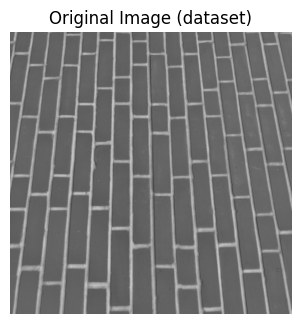

In [40]:
# Real image loader helpers
import os, glob

HTTP_HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0 Safari/537.36'
}

def load_image_from_url(url):
    """Load image from URL with robust error handling"""
    try:
        resp = requests.get(url, headers=HTTP_HEADERS, timeout=20)
        if resp.status_code != 200:
            print(f"HTTP {resp.status_code} for {url}")
            return None
        ctype = resp.headers.get('Content-Type', '')
        if not (ctype.startswith('image/') or url.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff','.bmp'))):
            print(f"Warning: non-image content-type '{ctype}' for {url}")
        bio = BytesIO(resp.content)
        img = Image.open(bio)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return img
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        return None

def load_image_from_local(glob_pattern):
    """Load image from local filesystem"""
    paths = sorted([p for p in glob.glob(glob_pattern, recursive=True)
                    if os.path.isfile(p) and p.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff','.bmp'))])
    if not paths:
        print(f"No local images found under pattern: {glob_pattern}")
        return None
    try:
        img = Image.open(paths[0])
        if img.mode != 'RGB':
            img = img.convert('RGB')
        print(f"✓ Loaded local image: {paths[0]}")
        return img
    except Exception as e:
        print(f"Error loading local image: {e}")
        return None

def load_dataset_image(dataset_type='generic'):
    """Load image based on dataset type parameter - checks local files first, then URLs"""
    if dataset_type not in DATASET_URLS:
        print(f"Unknown dataset type: {dataset_type}")
        print(f"Available types: {list(DATASET_URLS.keys())}")
        dataset_type = 'generic'
    
    print(f"Attempting to load {dataset_type} dataset...")
    
    # FIRST: Check local dataset paths
    if dataset_type in LOCAL_DATASET_PATHS:
        local_path = LOCAL_DATASET_PATHS[dataset_type]
        print(f"Checking local path: {local_path}")
        img = load_image_from_local(local_path)
        if img is not None:
            return img
    
    # FALLBACK: Try URLs if local files not found
    print(f"Local files not found, trying URLs...")
    urls = DATASET_URLS[dataset_type]
    for url in urls:
        img = load_image_from_url(url)
        if img is not None:
            print(f"Successfully loaded from: {url}")
            return img
    
    print(f"Failed to load any image from {dataset_type} dataset")
    return None

# Select image source based on DATA_SOURCE parameter
sample_image = None

if DATA_SOURCE == 'urls':
    # Use first available URL from dataset type
    for url in DATASET_URLS.get(DATASET_TYPE, DATASET_URLS['generic']):
        sample_image = load_image_from_url(url)
        if sample_image is not None:
            print(f"Loaded image from: {url}")
            break

elif DATA_SOURCE == 'local':
    sample_image = load_image_from_local(LOCAL_IMAGE_GLOB)

elif DATA_SOURCE == 'dataset':
    # Use parameterized dataset loader (checks local files first)
    sample_image = load_dataset_image(DATASET_TYPE)

# Fallback to synthetic if nothing worked
if sample_image is None:
    print("⚠ Falling back to synthetic image")
    np.random.seed(42)
    img_array = np.random.rand(224, 224, 3) * 255
    img_array[50:150, 50:150] = [255, 0, 0]
    img_array[100:200, 100:200] = [0, 255, 0]
    sample_image = Image.fromarray(img_array.astype(np.uint8))

# Display the original image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title(f"Original Image ({DATA_SOURCE})")
plt.axis('off')

# Preprocess for model based on type
if USE_HF_PROCESSOR:
    input_tensor = preprocess_image_hf(sample_image)
else:
    if sample_image.mode != 'RGB':
        sample_image = sample_image.convert('RGB')
    input_tensor = transform(sample_image).unsqueeze(0).to(device)

input_viz = transform_viz(sample_image).unsqueeze(0)

print(f"Input tensor shape: {input_tensor.shape}")
print(f"Model type: {'Hugging Face ViT' if USE_HF_PROCESSOR else 'Torchvision ResNet18'}")

## 5. Make Predictions

In [30]:
# Make prediction
with torch.no_grad():
    output = model(input_tensor)
    probabilities = F.softmax(output, dim=1)
    top5_prob, top5_idx = torch.topk(probabilities, 5)

# Display top 5 predictions
print("Top 5 Predictions:")
print("-" * 40)
for i in range(5):
    idx = top5_idx[0][i].item()
    prob = top5_prob[0][i].item()
    class_name = get_class_name(idx)
    print(f"{i+1}. {class_name} ({idx}): {prob:.4f}")

# Get the predicted class
predicted_class = top5_idx[0][0].item()
predicted_prob = top5_prob[0][0].item()
print(f"\nPredicted class: {get_class_name(predicted_class)} (confidence: {predicted_prob:.4f})")

Top 5 Predictions:
----------------------------------------
1. radiator (753): 0.2394
2. prison (743): 0.1029
3. window screen (904): 0.0860
4. honeycomb (599): 0.0457
5. space heater (811): 0.0388

Predicted class: radiator (confidence: 0.2394)


## 6. GradientSHAP Attribution

In [31]:
# Initialize GradientSHAP
gradient_shap = GradientShap(model)

# Create baseline (random noise baselines)
# GradientSHAP requires multiple baselines for better estimates
n_samples = 50  # Number of baseline samples
baselines = torch.randn(n_samples, *input_tensor.shape[1:]).to(device) * 0.1

print(f"Computing GradientSHAP attributions with {n_samples} baselines...")
print(f"Baseline shape: {baselines.shape}")

# Compute attributions for the predicted class
attributions = gradient_shap.attribute(
    input_tensor,
    baselines=baselines,
    target=predicted_class,
    n_samples=10,  # Number of samples for approximation
    stdevs=0.09    # Standard deviation for noise
)

print(f"Attribution shape: {attributions.shape}")
print(f"Attribution range: [{attributions.min():.4f}, {attributions.max():.4f}]")

Computing GradientSHAP attributions with 50 baselines...
Baseline shape: torch.Size([50, 3, 224, 224])
Attribution shape: torch.Size([1, 3, 224, 224])
Attribution range: [-0.0321, 0.0417]
Attribution shape: torch.Size([1, 3, 224, 224])
Attribution range: [-0.0321, 0.0417]
Attribution shape: torch.Size([1, 3, 224, 224])
Attribution range: [-0.0321, 0.0417]


## 7. Visualize Attribution Results

In [32]:
# Convert attributions to numpy for visualization
attributions_np = attributions.squeeze().cpu().detach().numpy()
input_viz_np = input_viz.squeeze().cpu().detach().numpy()

# Transpose from (C, H, W) to (H, W, C) for visualization
attributions_np = np.transpose(attributions_np, (1, 2, 0))
input_viz_np = np.transpose(input_viz_np, (1, 2, 0))

print(f"Visualization arrays shape: {input_viz_np.shape}, {attributions_np.shape}")

Visualization arrays shape: (224, 224, 3), (224, 224, 3)


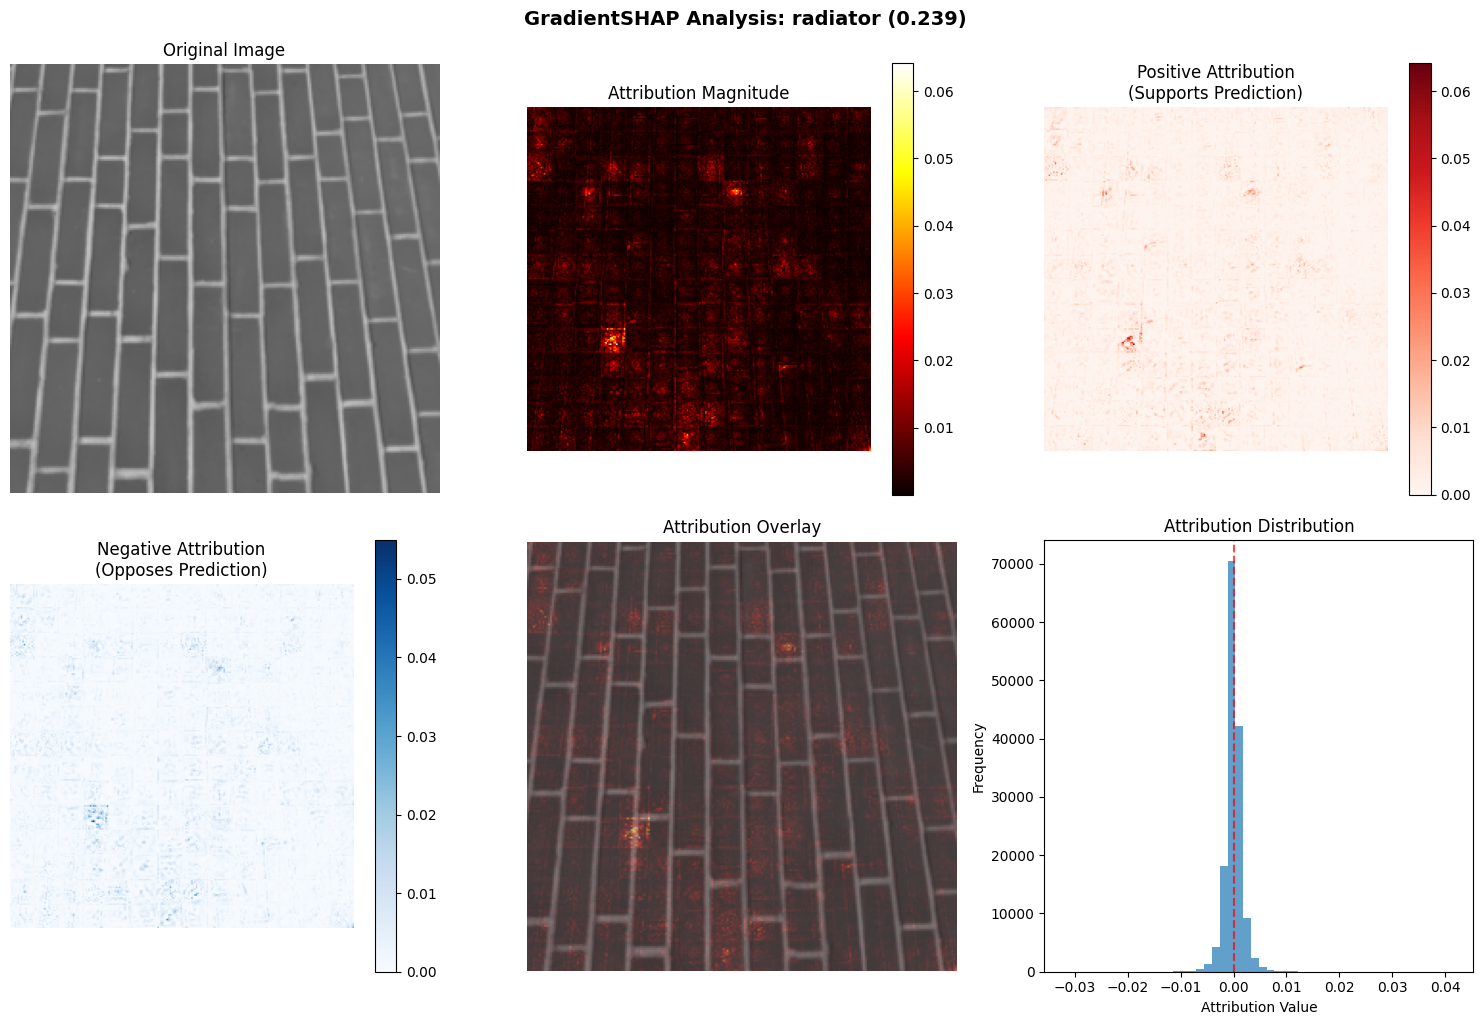

In [33]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original image
axes[0, 0].imshow(input_viz_np)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# Attribution heatmap (sum across channels)
attr_sum = np.sum(np.abs(attributions_np), axis=2)
im1 = axes[0, 1].imshow(attr_sum, cmap='hot')
axes[0, 1].set_title('Attribution Magnitude')
axes[0, 1].axis('off')
plt.colorbar(im1, ax=axes[0, 1])

# Positive attributions (what supports the prediction)
attr_pos = np.sum(np.maximum(attributions_np, 0), axis=2)
im2 = axes[0, 2].imshow(attr_pos, cmap='Reds')
axes[0, 2].set_title('Positive Attribution\n(Supports Prediction)')
axes[0, 2].axis('off')
plt.colorbar(im2, ax=axes[0, 2])

# Negative attributions (what opposes the prediction)
attr_neg = np.sum(np.minimum(attributions_np, 0), axis=2)
im3 = axes[1, 0].imshow(np.abs(attr_neg), cmap='Blues')
axes[1, 0].set_title('Negative Attribution\n(Opposes Prediction)')
axes[1, 0].axis('off')
plt.colorbar(im3, ax=axes[1, 0])

# Overlay: original image with attribution
# Normalize attribution for overlay
attr_normalized = (attr_sum - attr_sum.min()) / (attr_sum.max() - attr_sum.min())
axes[1, 1].imshow(input_viz_np)
axes[1, 1].imshow(attr_normalized, alpha=0.4, cmap='hot')
axes[1, 1].set_title('Attribution Overlay')
axes[1, 1].axis('off')

# Attribution histogram
axes[1, 2].hist(attributions_np.flatten(), bins=50, alpha=0.7)
axes[1, 2].set_title('Attribution Distribution')
axes[1, 2].set_xlabel('Attribution Value')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].axvline(x=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.suptitle(f'GradientSHAP Analysis: {get_class_name(predicted_class)} ({predicted_prob:.3f})', 
             y=1.02, fontsize=14, fontweight='bold')
plt.show()

## 8. Compare with Other Attribution Methods

In [34]:
# Compare GradientSHAP with other attribution methods
print("Computing attributions with different methods for comparison...")

# Saliency (vanilla gradients)
saliency = Saliency(model)
saliency_attr = saliency.attribute(input_tensor, target=predicted_class)

# Integrated Gradients
integrated_gradients = IntegratedGradients(model)
ig_attr = integrated_gradients.attribute(input_tensor, target=predicted_class, n_steps=50)

print("Attribution methods computed successfully!")

Computing attributions with different methods for comparison...
Attribution methods computed successfully!
Attribution methods computed successfully!
Attribution methods computed successfully!


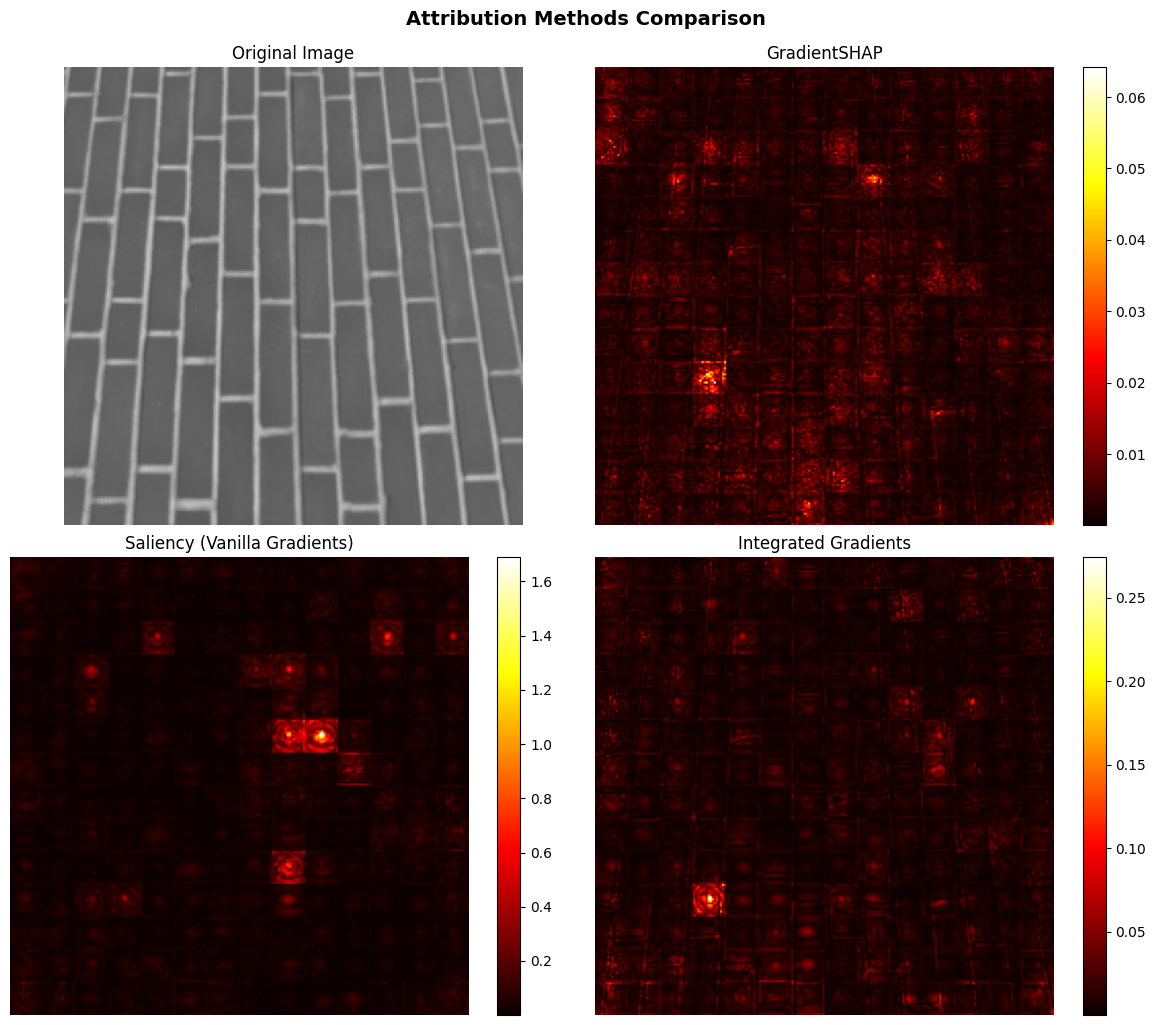

In [35]:
# Visualization comparison
def normalize_attribution(attr):
    """Normalize attribution for consistent visualization"""
    attr_np = attr.squeeze().cpu().detach().numpy()
    attr_np = np.transpose(attr_np, (1, 2, 0))
    return np.sum(np.abs(attr_np), axis=2)

# Normalize all attributions
gradshap_viz = normalize_attribution(attributions)
saliency_viz = normalize_attribution(saliency_attr)
ig_viz = normalize_attribution(ig_attr)

# Create comparison plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original image
axes[0, 0].imshow(input_viz_np)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# GradientSHAP
im1 = axes[0, 1].imshow(gradshap_viz, cmap='hot')
axes[0, 1].set_title('GradientSHAP')
axes[0, 1].axis('off')
plt.colorbar(im1, ax=axes[0, 1])

# Saliency
im2 = axes[1, 0].imshow(saliency_viz, cmap='hot')
axes[1, 0].set_title('Saliency (Vanilla Gradients)')
axes[1, 0].axis('off')
plt.colorbar(im2, ax=axes[1, 0])

# Integrated Gradients
im3 = axes[1, 1].imshow(ig_viz, cmap='hot')
axes[1, 1].set_title('Integrated Gradients')
axes[1, 1].axis('off')
plt.colorbar(im3, ax=axes[1, 1])

plt.tight_layout()
plt.suptitle('Attribution Methods Comparison', y=1.02, fontsize=14, fontweight='bold')
plt.show()

## 9. Quantitative Analysis

In [36]:
# Compute attribution statistics
def compute_attribution_stats(attr, name):
    """Compute statistics for attribution map"""
    attr_flat = attr.flatten()
    stats = {
        'method': name,
        'mean': np.mean(attr_flat),
        'std': np.std(attr_flat),
        'min': np.min(attr_flat),
        'max': np.max(attr_flat),
        'sum_abs': np.sum(np.abs(attr_flat)),
        'sparsity': np.sum(np.abs(attr_flat) < 0.01) / len(attr_flat)
    }
    return stats

# Compute stats for all methods
stats_list = [
    compute_attribution_stats(gradshap_viz, 'GradientSHAP'),
    compute_attribution_stats(saliency_viz, 'Saliency'),
    compute_attribution_stats(ig_viz, 'Integrated Gradients')
]

# Display statistics
import pandas as pd

stats_df = pd.DataFrame(stats_list)
print("Attribution Method Statistics:")
print("=" * 50)
print(stats_df.round(4))

# Interpretation
print("\nInterpretation:")
print(f"• Sparsity: Lower values indicate more diffuse attributions")
print(f"• Sum of absolute values: Total attribution magnitude")
print(f"• GradientSHAP typically provides more stable and interpretable results")

Attribution Method Statistics:
                 method    mean     std     min     max      sum_abs  sparsity
0          GradientSHAP  0.0033  0.0029  0.0000  0.0642   166.029007    0.9710
1              Saliency  0.0397  0.0573  0.0009  1.6901  1991.794189    0.0905
2  Integrated Gradients  0.0095  0.0093  0.0000  0.2746   477.343994    0.6723

Interpretation:
• Sparsity: Lower values indicate more diffuse attributions
• Sum of absolute values: Total attribution magnitude
• GradientSHAP typically provides more stable and interpretable results


## 10. Summary and Key Insights

In [37]:
print("GradientSHAP Analysis Summary")
print("=" * 50)
model_name_display = "Hugging Face ViT-Base" if USE_HF_PROCESSOR else "TorchVision ResNet18"
print(f"Model: {model_name_display} (pretrained on ImageNet)")
print(f"Predicted class: {get_class_name(predicted_class)}")
print(f"Confidence: {predicted_prob:.4f}")
print(f"\nKey Findings:")
print(f"• GradientSHAP attribution range: [{attributions.min():.4f}, {attributions.max():.4f}]")
print(f"• Number of baseline samples: {n_samples}")
print(f"• Attribution method provides pixel-level explanations")

print(f"\nGradientSHAP Advantages:")
print(f"• Combines gradient information with SHAP methodology")
print(f"• More stable than vanilla gradients")
print(f"• Theoretically grounded in game theory")
print(f"• Handles baseline distribution effectively")

print(f"\nTechnical Details:")
print(f"• Captum version: Available in captum.attr.GradientShap")
print(f"• Computation time: Depends on n_samples and model complexity")
print(f"• Memory usage: Scales with baseline samples")
print(f"• Best for: Deep neural networks, image classification")

print(f"\nReferences:")
print(f"• Captum Documentation: https://captum.ai/api/gradient_shap.html")
print(f"• SHAP Paper: Lundberg & Lee (2017)")
print(f"• GradientSHAP: Erion et al. (2019)")

GradientSHAP Analysis Summary
Model: Hugging Face ViT-Base (pretrained on ImageNet)
Predicted class: radiator
Confidence: 0.2394

Key Findings:
• GradientSHAP attribution range: [-0.0321, 0.0417]
• Number of baseline samples: 50
• Attribution method provides pixel-level explanations

GradientSHAP Advantages:
• Combines gradient information with SHAP methodology
• More stable than vanilla gradients
• Theoretically grounded in game theory
• Handles baseline distribution effectively

Technical Details:
• Captum version: Available in captum.attr.GradientShap
• Computation time: Depends on n_samples and model complexity
• Memory usage: Scales with baseline samples
• Best for: Deep neural networks, image classification

References:
• Captum Documentation: https://captum.ai/api/gradient_shap.html
• SHAP Paper: Lundberg & Lee (2017)
• GradientSHAP: Erion et al. (2019)


## Model Comparison: Hugging Face ViT vs TorchVision ResNet

This notebook demonstrates how to use GradientSHAP with different model architectures:

### Hugging Face Vision Transformer (ViT)
- **Model**: `google/vit-base-patch16-224`
- **Parameters**: ~86M parameters  
- **Architecture**: Transformer-based vision model
- **Preprocessing**: Automatic via Hugging Face processor
- **Advantages**: 
  - State-of-the-art performance on many vision tasks
  - Attention-based architecture provides interpretable attention maps
  - Easy integration with Hugging Face ecosystem

### TorchVision ResNet18
- **Model**: `torchvision.models.resnet18`
- **Parameters**: ~11M parameters
- **Architecture**: Convolutional neural network
- **Preprocessing**: Manual normalization with ImageNet statistics
- **Advantages**:
  - Smaller model size, faster inference
  - Well-established architecture
  - Lower computational requirements

### Switching Between Models
To switch models, simply change the `MODEL_TYPE` variable in cell 2:
- `MODEL_TYPE = "huggingface"` for Vision Transformer
- `MODEL_TYPE = "torchvision"` for ResNet18

Both models work seamlessly with Captum's GradientSHAP implementation!